<a href="https://colab.research.google.com/github/JackGraymer/Advanced-GenAI/blob/main/3_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Generative Artificial Intelligence
**Project - Designing a RAG-Based Q&A System for News Retrieval**

**Authors:** Vsevolod Mironov, Pascal Küng, Alvaro Cervan (Group 5)


# Step 3 Evaluation – Assessing answer quality through both automated and human evaluation

**Contribution:** Vsevolod Mironov, Pascal Küng, Alvaro Cervan

**Goal of this step:** Students will assess the quality of answers produced by their top-performing RAG pipeline. This involves applying the pipeline to benchmark questions, comparing its responses to ground truth answers, and evaluating performance using both automated metrics and human judgment.

### **Objective**
Evaluate the quality of answers generated by the best RAG pipeline using both automated metrics and human judgment.

---

### **Workflow**

1. **Run the Best RAG Pipeline**
	- Apply the developed RAG pipeline to the benchmark question set to generate answers.

2. **Automated Metrics Calculation**
	- **Semantic Exact Match:** Assess if generated answers semantically match ground truth using embeddings or semantic models.
	- **Semantic F1 Score:** Tokenize answers and compute precision, recall, and F1 based on semantic similarity.
	- **BLEU/ROUGE:** Measure N-gram or sequence overlap between generated and ground truth answers.
	- **Record Results:** Store all metric scores in a structured format for comparison.

3. **Human Evaluation**
	- **Criteria:** Evaluate each answer for:
	  - *Relevance* (alignment with the query)
	  - *Correctness* (accuracy vs. ground truth)
	  - *Clarity* (understandability)
	- **Rating Scale:** Use a 1–5 scale for each criterion.
	- **Analysis:** Provide a brief written summary of human evaluation findings.

4. **Report and Presentation**
	- Present both automated and human evaluation results using tables, charts, or other concise visualizations within the notebook.

#### Visual Representation of the Evaluation Pipeline
![Pipeline Overview](https://github.com/JackGraymer/Advanced-GenAI/blob/main/Evaluation_Workflow.svg?raw=1)

---

**Summary Table Example:**

| Question | Automated Metrics (F1, BLEU, ROUGE) | Human Relevance | Human Correctness | Human Clarity | Comments |
|----------|-------------------------------------|-----------------|-------------------|--------------|----------|
| Q1       | ...                                 | ...             | ...               | ...          | ...      |



# 1.0 Loading Data and functions from previous stage

## 1.1 Setup of the environment

In [ ]:
!pip install torch torchvision torchaudio
!pip install --quiet --upgrade openai

In [2]:
import torch
if torch.cuda.is_available():
    print(f"GPU is available: {torch.cuda.get_device_name(0)}")
    # The model will automatically be placed on the GPU
else:
    print("GPU is not available. Running on CPU.")

GPU is available: Tesla T4


In [ ]:
import os
import re
import json
import asyncio
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
import matplotlib.pyplot as plt
import seaborn as sns
import pprint
import pickle
from typing import Optional, List
from sentence_transformers import SentenceTransformer, util
from transformers import AutoModelForCausalLM, AutoTokenizer, AutoModelForSequenceClassification
from google.colab import userdata

In [3]:
# Set the seed for consistent results
seed_value = 2138247234
random.seed(seed_value)
np.random.seed(seed_value)
os.environ['PYTHONHASHSEED'] = str(seed_value)

## 1.2a Setup for working on Colab

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
base_folder = '/content/drive/MyDrive/AdvGenAI'

In [7]:
# Load dictionary of precalculated retrieved chunks
filename = os.path.join(base_folder, "Stage3/Working-dir/Stage3-02-precalc-reranked-chunks.pkl")
with open(filename, 'rb') as f:
    precalc_reranked_chunks = pickle.load(f)
print(f"Dictionary loaded from {filename}:")

Dictionary loaded from /content/drive/MyDrive/AdvGenAI/Stage3/Working-dir/Stage3-02-precalc-reranked-chunks.pkl:


In [8]:
df = pd.read_csv(os.path.join(base_folder, 'Stage2/Working-dir/Stage2-02-chunked-dataset.csv'))

In [9]:
# Load Q_A_data file
with open(os.path.join(base_folder, 'Stage2/Working-dir/Stage2-08-q-a-file-with-relevancy.pkl'), 'rb') as f:
    question_answers = pickle.load(f)

In [26]:
# Define OpenAI Api Key
import openai
from google.colab import userdata

OPENAI_API_KEY = userdata.get('openai_advAI')

## 1.2b Setup for working locally

In [4]:
# Run this cell if working locally
df = pd.read_csv('data/Stage2-02-chunked-dataset.csv')
filename = 'data/Stage3-02-precalc-reranked-chunks.pkl'
with open(filename, 'rb') as f:
	precalc_reranked_chunks = pickle.load(f)
print(f"Dictionary loaded from {filename}:")

with open('data/Stage2-08-q-a-file-with-relevancy.pkl', 'rb') as f_qa:
	question_answers = pickle.load(f_qa)

# load files in local computer and api from data .env
from dotenv import dotenv_values

env_vars = dotenv_values('data/.env')
OPENAI_API_KEY = env_vars.get('OPENAI_API_KEY', None)
print(f"Loaded OPENAI_API_KEY: {'***' if OPENAI_API_KEY else 'Not found'}")

Dictionary loaded from data/Stage3-02-precalc-reranked-chunks.pkl:
Loaded OPENAI_API_KEY: ***


## 1.3 Inspect loaded data

In [5]:
df.head()

,unique_chunk_id,chunk_text,chunk_length,total_chunks,folder_path,file_name,year,month,language,type,title,text_id,chunk_id
0,0000_00,"Als 1950 die Meteorologen Jule Charney, Ragnar...",563,8,/content/drive/MyDrive/AdvGenAI/data/de_news_e...,blog-knutti-klimamodelle.html,2019,8,de,news events,Blog knutti klimamodelle,0,0
1,0000_01,## Erstaunliche Entwicklung der Klimamodelle\n...,804,8,/content/drive/MyDrive/AdvGenAI/data/de_news_e...,blog-knutti-klimamodelle.html,2019,8,de,news events,Blog knutti klimamodelle,0,1
2,0000_02,"«Alle Modelle sind falsch, aber einige sind nü...",881,8,/content/drive/MyDrive/AdvGenAI/data/de_news_e...,blog-knutti-klimamodelle.html,2019,8,de,news events,Blog knutti klimamodelle,0,2
3,0000_03,"Doch um die Gitterweite verkleinern zu können,...",536,8,/content/drive/MyDrive/AdvGenAI/data/de_news_e...,blog-knutti-klimamodelle.html,2019,8,de,news events,Blog knutti klimamodelle,0,3
4,0000_04,Bis ein hochaufgelöstes Modell auf einer neuen...,466,8,/content/drive/MyDrive/AdvGenAI/data/de_news_e...,blog-knutti-klimamodelle.html,2019,8,de,news events,Blog knutti klimamodelle,0,4


In [6]:
# print filename to see the content of the .pkl file
print(f"Precalculated retrieved chunks: {len(precalc_reranked_chunks)} entries")
# Print the first few entries to understand the structure
print("Sample entries from precalculated retrieved chunks:")
for key, value in list(precalc_reranked_chunks.items())[:2]:
	print(f"Key: {key}")
	display(value.head(3))
	print("------------------------------------------------------------\n")

Precalculated retrieved chunks: 25 entries
Sample entries from precalculated retrieved chunks:
Key: Who was president of ETH in 2003?


,unique_chunk_id,score,chunk_text,title
0,3429_06,0.048395,"The President of the ETH Board, Fritz Schiesse...",New president appointed
1,3795_08,0.047403,"ETH President Ralph Eichler, who is handing ov...",Encouraging more critical opinion
2,3947_09,0.047139,While ETH Zurich has always had an open and in...,A grounded globetrotter


------------------------------------------------------------

Key: Who were the rectors of ETH between 2017 and 2022?


,unique_chunk_id,score,chunk_text,title
0,3871_02,0.048916,## Big changes on all study levels\nOver the p...,Eth day 2019
1,2371_01,0.048139,"""I am excited about the opportunity to contrib...",New head of let
2,2814_00,0.047883,"Last Tuesday, the Professors’ Conference of ET...",Guenther dissertori as new eth zurich rector


------------------------------------------------------------



Below we convert the dictionary containing the questions and answers to a dataframe and keep only the columns of `question`, `answer` and `evaluation_comments`.

In [7]:
# convert question_answers to a DataFrame
qa_df = pd.DataFrame(question_answers)
# Display the first few rows of the DataFrame
print("Question-Answers DataFrame:")
qa_df = qa_df.T
qa_df = qa_df.drop(['possible_relevant_chunks', 'ground_truth_relevance'], axis=1)
qa_df.head()

Question-Answers DataFrame:


,question,answer,evaluation_comments
1,Who was president of ETH in 2003?,Olaf Kübler,
2,Who were the rectors of ETH between 2017 and 2...,"Sarah Springman, Günther Dissertori",
3,Who at ETH received ERC grants?,European Research Council grants: Tobias Donne...,The criterion here: does it come up with a lis...
4,When did the InSight get to Mars?,26 November 2018,
5,What did Prof. Schubert say about ﬂying?,Flying is too cheap. If we want to reduce ﬂyin...,


# 2.0 Answer the questions

## 2.1 Let an LLM (OpenAI) answer questions without context

In [8]:
import openai

client = openai.OpenAI(api_key=OPENAI_API_KEY)

def ask_chatgpt(question, model="gpt-4o"):
	try:
		response = client.chat.completions.create(
			model=model,
			messages=[{"role": "user", "content": question}],
			temperature=0
		)
		return response.choices[0].message.content.strip()
	except Exception as e:
		return f"Error: {e}"

In [9]:
# Query ChatGPT for each question and store the answer
for idx, row in qa_df.iterrows():
	answer = ask_chatgpt(row['question'])
	qa_df.at[idx, 'GPT_4o_no_context'] = answer

In [10]:
qa_df.head()

,question,answer,evaluation_comments,GPT_4o_no_context
1,Who was president of ETH in 2003?,Olaf Kübler,,"In 2003, the president of ETH Zurich (Swiss Fe..."
2,Who were the rectors of ETH between 2017 and 2...,"Sarah Springman, Günther Dissertori",,"Between 2017 and 2022, the rector of ETH Zuric..."
3,Who at ETH received ERC grants?,European Research Council grants: Tobias Donne...,The criterion here: does it come up with a lis...,ETH Zurich has been successful in securing num...
4,When did the InSight get to Mars?,26 November 2018,,NASA's InSight lander arrived on Mars on Novem...
5,What did Prof. Schubert say about ﬂying?,Flying is too cheap. If we want to reduce ﬂyin...,,"I'm sorry, but I need more context to provide ..."


In [30]:
# save Questions and Answers
qa_df.to_csv(os.path.join(base_folder, 'Stage4/Working-dir/Stage4-01-q-a.csv'), index=False)

## 2.2 Setup for question answering using the retrieved and contexts

In [32]:
# Load Questions and Answers
qa_df = pd.read_csv(os.path.join(base_folder, 'Stage4/Working-dir/Stage4-01-q-a.csv'))

For some question the month and year of publication might be of interest. Therefore we will send that to the LLM together with the context and chunk_id.

In [11]:
# Function to return the month as text from the number
def get_month_name(month_number):
    months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
    return months[month_number - 1]

In [12]:
# As an example
chunk_id = "2101_01"
month = df[df['unique_chunk_id']==chunk_id]['month'].item()
year = df[df['unique_chunk_id']==chunk_id]['year'].item()
print(f"Published in: {get_month_name(month)} {year}")

Published in: September 2022


We provide the information of the relevant chunks in a JSON format and also request the answer to be in a valid JSON-format for easier handling.

In the system prompt we provide the LLM with guidelines for answering the question. We ask it to answer the questions solely based on the information provided in the contexts. If we would relax this restriction the LLM might be able to answer some of the questions where it doesn't provide one solely based on the provided contexts (for example the question "Who was president of ETH in 2003?")

In [13]:
def ask_chatgpt_with_rag_context(question: str, top_k: int = 10, model: str = "gpt-4o") -> dict:
    """
    RAG-enhanced call that provides context as JSON and requests a JSON output.
    The response includes the answer and the specific chunks used.
    """
    if question not in precalc_reranked_chunks:
        return {"error": f"No retrieved chunks for: {question}"}

    try:
        # --- 1. Retrieve and Format Context Chunks ---
        top_chunks_df = precalc_reranked_chunks[question].sort_values("score", ascending=False).head(top_k)

        context_chunks_list = []
        for _, row in top_chunks_df.iterrows():
            cid = row["unique_chunk_id"]
            match = df[df["unique_chunk_id"] == cid]

            if not match.empty:
                match_row = match.iloc[0]
                context_chunks_list.append({
                    "unique_chunk_id": cid,
                    "publication_date": f"{get_month_name(match_row['month'])} {match_row['year']}",
                    "text": match_row["chunk_text"]
                })

        # Convert the list of dictionaries to a JSON string
        context_json_str = json.dumps(context_chunks_list, indent=2)

        # --- 2. Construct the System Prompt ---
        system_prompt = f"""You are a professional AI assistant for the ETH Zurich news website.

**Your Task:**
1.  You will be given a user's question and a list of context chunks from news articles in JSON format.
2.  Formulate a short, precise, and professional answer based **exclusively** on the provided context.
3.  Your tone must be neutral and objective, representing ETH Zurich as a whole. Do not favor any disciplines or departments.
4.  Identify the `unique_chunk_id` of every chunk you use to formulate the answer.
5.  Omit boilerplate intros like “Based on the context provided.”
6.  If the context does not contain the information needed to answer, your answer should state that the information is not available in the provided articles.

**Output Format:**
You MUST respond with a single, valid JSON object and nothing else. The schema is:
{{
  "relevant_chunks": ["id_of_chunk_1", "id_of_chunk_2"],
  "answer": "Your concise and professional answer here."
}}"""

        # --- 3. Construct the User Prompt ---
        user_prompt = f"""Context Chunks:
{context_json_str}

Question:
{question}
"""
        # --- 4. Call the OpenAI API with JSON Mode ---
        response = client.chat.completions.create(
            model=model,
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": user_prompt}
            ],
            temperature=0,
            response_format={"type": "json_object"} # Enforce JSON output
        )

        # Parse the JSON response from the model
        response_content = response.choices[0].message.content
        return json.loads(response_content)

    except Exception as e:
        return {"error": f"An exception occurred: {e}"}

Below we ask one of the question to test the function.

In [14]:
question_to_ask = "Who at ETH received ERC grants?"
response_dict = ask_chatgpt_with_rag_context(question_to_ask)

if 'error' not in response_dict:
    print("Answer from Chatbot:")
    print(response_dict.get("answer"))

    print("\nSources Used (Chunk IDs):")
    print(response_dict.get("relevant_chunks"))

else:
    print(f"An error occurred: {response_dict['error']}")

Answer from Chatbot:
Several researchers at ETH Zurich have received ERC grants. Professor Ruedi Aebersold and Professor Atac Imamoglu have received ERC Advanced Grants. Martin Vechev was awarded an ERC Starting Grant. Barbara Treutlein and Nicolas Noiray received ERC Synergy Grants for their projects 'AxoBrain' and 'HYROPE', respectively. Christoph Müller received an ERC Consolidator Grant in 2018.

Sources Used (Chunk IDs):
['3509_00', '3087_01', '4139_00', '3888_06']


## 2.3 Process all questions with an LLM using the retrieved contexts

Below we check the provided chunks to check if they are indeed containing the context as a basis for the answer of the LLM.

For this question the retrieved (and reranked) chunks provide a very good basis for answering the question.

In [16]:
for chunk_id in response_dict.get("relevant_chunks"):
    row = df[df["unique_chunk_id"] == chunk_id]
    print(f"Chunk ID: {chunk_id}")
    pprint.pprint(row["chunk_text"].item())

Chunk ID: 3509_00
('ERC Advanced Grants are very popular among researchers throughout Europe, as '
 'only top researchers’ projects are supported by the European Research '
 'Council (ERC). The grants are therefore considered a special distinction. In '
 'addition, researchers welcome the significant funds: the approved projects '
 'receive from CHF 2.5 million to CHF 3.5 million over a period of five '
 'years.\n'
 'The success rate of ETH researchers is an impressive 33%: seven of the 21 '
 'projects submitted were approved for an ERC Advanced Grant. Professor Ruedi '
 'Aebersold, head of the Institute of Molecular Systems Biology, and Professor '
 'Atac Imamoglu, head of the Institute of Quantum Electronics, were successful '
 'for a second time. In total, ETH researchers received the amount of 16.6 mio '
 'swiss francs.')
Chunk ID: 3087_01
('## Latecomer for Starting Grants\n'
 'In December of last year,\xa0 ETH News\xa0 announced that seven ETH '
 'researchers had successfully app

Below we iterate over the list of questions and print the answers and ids of the relevant chunks. Additionally we save the answers in the `qa_df`.

In [ ]:
for idx, row in qa_df.iterrows():
    q = row["question"]
    print(f"⏳ Answering: {q[:80]}...")
    answer_dict = ask_chatgpt_with_rag_context(q, top_k=10)
    if "Error" in answer:
        print(f"❌ Error for question {q}")
        pprint.pprint(answer_dict)
        qa_df.at[idx, 'GPT_4o_RAG_response'] = ""

    else:
        print("✓ Success. Response received:")
        pprint.pprint(answer_dict)
        qa_df.at[idx, 'GPT_4o_RAG_response'] = answer_dict.get("answer")

⏳ Answering: Who was president of ETH in 2003?...
✓ Success. Response received:
{'answer': 'The information about who was president of ETH Zurich in 2003 is '
           'not available in the provided articles.',
 'relevant_chunks': []}
⏳ Answering: Who were the rectors of ETH between 2017 and 2022?...
✓ Success. Response received:
{'answer': 'Sarah Springman served as Rector of ETH Zurich from 2015 until '
           '2022. In March 2021, Günther Dissertori was nominated to succeed '
           'her as Rector. Therefore, between 2017 and 2022, Sarah Springman '
           'was the Rector, with Günther Dissertori nominated as her successor '
           'in 2021.',
 'relevant_chunks': ['4047_00', '2814_00']}
⏳ Answering: Who at ETH received ERC grants?...
✓ Success. Response received:
{'answer': 'Numerous researchers at ETH Zurich have received ERC grants across '
           'various categories. More than 80 researchers have been awarded ERC '
           'Advanced Grants. Notable recipi

In [18]:
qa_df.head()

,question,answer,evaluation_comments,GPT_4o_no_context,GPT_4o_RAG_response
1,Who was president of ETH in 2003?,Olaf Kübler,,"In 2003, the president of ETH Zurich (Swiss Fe...",The information about who was president of ETH...
2,Who were the rectors of ETH between 2017 and 2...,"Sarah Springman, Günther Dissertori",,"Between 2017 and 2022, the rector of ETH Zuric...",Sarah Springman served as Rector of ETH Zurich...
3,Who at ETH received ERC grants?,European Research Council grants: Tobias Donne...,The criterion here: does it come up with a lis...,ETH Zurich has been successful in securing num...,Numerous researchers at ETH Zurich have receiv...
4,When did the InSight get to Mars?,26 November 2018,,NASA's InSight lander arrived on Mars on Novem...,The InSight lander successfully arrived on Mar...
5,What did Prof. Schubert say about ﬂying?,Flying is too cheap. If we want to reduce ﬂyin...,,"I'm sorry, but I need more context to provide ...",Prof. Renate Schubert stated that while surcha...


In [52]:
# save Questions and Answers
qa_df.to_csv(os.path.join(base_folder, 'Stage4/Working-dir/Stage4-02-q-a.csv'), index=False)

# 3.0 Evaluation of the answers
The answers provided by the LLM are evaluated in 2 ways:
1. **Automated Metrics Calculation**: We calculate **semantic Exact Match**, **semantic F1 Score**, and **BLEU/ROUGE** scores to quantify the quality of the answers.
2. **Human Evaluation**: We assess the answers based on relevance, correctness, and clarity using a 1-5 rating scale.



In [ ]:
# Load Questions and Answers
qa_df = pd.read_csv(os.path.join(base_folder, 'Stage4/Working-dir/Stage4-02-q-a.csv'))

In [ ]:
# load locally
qa_df = pd.read_csv('data/Stage4-02-q-a.csv')

## 3.1 Automated Metrics Calculation

### 3.1.1 Semantic Exact Match

To assess how closely the GPT-4o RAG-generated answers match the original reference answers in `qa_df`, we use semantic similarity rather than strict word overlap. Both the reference and generated answers are embedded using a pretrained sentence transformer (`all-MiniLM-L6-v2`). Cosine similarity is then calculated between each answer pair to measure their semantic closeness. The resulting similarity score is stored in the `semantic_similarity` column, and a binary `semantic_match` flag is set based on a chosen threshold (e.g., ≥ 0.50). This approach captures whether two answers convey the same meaning, even if they use different wording, making it ideal for evaluating generative models like RAG.

In [43]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Load a lightweight semantic model (or use a multilingual one if needed)
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

# Embed both columns
answer_embeddings = model.encode(qa_df['answer'].tolist(), convert_to_tensor=True, normalize_embeddings=True)
response_embeddings = model.encode(qa_df['GPT_4o_RAG_response'].tolist(), convert_to_tensor=True, normalize_embeddings=True)

# Compute cosine similarity row-by-row
similarities = cosine_similarity(answer_embeddings.cpu(), response_embeddings.cpu()).diagonal()

# Adds semantic similarity score to DataFrame
qa_df['exact_match_similarity'] = similarities

# Optional: Adds binary match column based on threshold
threshold = 0.50  # Adjust as needed
qa_df['exact_match'] = qa_df['exact_match_similarity'] >= threshold

In [44]:
qa_df.head()

,question,answer,evaluation_comments,chatgpt_no_context,GPT_4o_RAG_response,exact_match_similarity,exact_match
0,Who was president of ETH in 2003?,Olaf Kübler,NaN,"In 2003, the president of ETH Zurich (Swiss Fe...",The information about who was president of ETH...,0.098289,False
1,Who were the rectors of ETH between 2017 and 2...,"Sarah Springman, Günther Dissertori",NaN,"Between 2017 and 2022, the rector of ETH Zuric...",Sarah Springman served as the Rector of ETH Zu...,0.609197,True
2,Who at ETH received ERC grants?,European Research Council grants: Tobias Donne...,The criterion here: does it come up with a lis...,ETH Zurich has been successful in securing num...,Several researchers at ETH Zurich have receive...,0.549049,True
3,When did the InSight get to Mars?,26 November 2018,NaN,NASA's InSight lander arrived on Mars on Novem...,The InSight lander successfully landed on Mars...,0.266089,False
4,What did Prof. Schubert say about ﬂying?,Flying is too cheap. If we want to reduce ﬂyin...,NaN,"I'm sorry, but I need more context to provide ...",Prof. Renate Schubert expressed that while sur...,0.723278,True


### 3.1.2 Semantic F1 Score
To compute the semantic F1 score, both the reference and generated answers are tokenized into words or short spans. Instead of requiring exact token matches, each token is embedded using a sentence embedding model (such as `all-MiniLM-L6-v2`). For each token in the generated answer, the most similar token in the reference answer is identified using cosine similarity. If the similarity exceeds a threshold (e.g., 0.8), it is counted as a match. Semantic precision is defined as the fraction of generated tokens that have a semantically similar match in the reference; semantic recall is the fraction of reference tokens matched by the generated answer. The semantic F1 score is the harmonic mean of these two. This approach is robust to paraphrasing and lexical variation, providing a more nuanced evaluation than strict token overlap.

In [45]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Load the embedding model
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

# Tokenizer function (can be replaced with more advanced tokenization if needed)
def tokenize(text):
    return [t.strip() for t in text.split() if t.strip()]

# Semantic matching function
def semantic_f1_score(reference: str, prediction: str, threshold=0.8):
    ref_tokens = tokenize(reference)
    pred_tokens = tokenize(prediction)
    
    if not ref_tokens or not pred_tokens:
        return 0.0, 0.0, 0.0  # precision, recall, f1 = 0

    ref_embeds = model.encode(ref_tokens, convert_to_tensor=True, normalize_embeddings=True)
    pred_embeds = model.encode(pred_tokens, convert_to_tensor=True, normalize_embeddings=True)

    sim_matrix = cosine_similarity(pred_embeds.cpu(), ref_embeds.cpu())

    matched_ref = set()
    matched_pred = set()

    for i, row in enumerate(sim_matrix):
        for j, score in enumerate(row):
            if score >= threshold and j not in matched_ref and i not in matched_pred:
                matched_pred.add(i)
                matched_ref.add(j)
                break

    precision = len(matched_pred) / len(pred_tokens)
    recall = len(matched_ref) / len(ref_tokens)
    if precision + recall == 0:
        f1 = 0.0
    else:
        f1 = 2 * (precision * recall) / (precision + recall)

    return precision, recall, f1


In [46]:
# Create new columns with updated names
qa_df['f1_precision'] = 0.0
qa_df['f1_recall'] = 0.0
qa_df['f1_score'] = 0.0

for i, row in qa_df.iterrows():
    ref = str(row['answer'])
    pred = str(row['GPT_4o_RAG_response'])
    p, r, f1 = semantic_f1_score(ref, pred)
    qa_df.at[i, 'f1_precision'] = p
    qa_df.at[i, 'f1_recall'] = r
    qa_df.at[i, 'f1_score'] = f1


This Measures:

- **Precision:** Indicates the proportion of words in the generated answer that are semantically similar to words in the reference answer. High precision means the generated answer is focused and relevant, with few unnecessary or unrelated words.

- **Recall:** Reflects how much of the reference answer is covered by semantically similar words in the generated answer. High recall means the generated answer captures most of the important content from the reference.

- **F1 Score:** The harmonic mean of precision and recall. A higher F1 score signifies better overall alignment in meaning between the generated and reference answers, balancing both completeness and relevance.

In [47]:
qa_df.head()

,question,answer,evaluation_comments,chatgpt_no_context,GPT_4o_RAG_response,exact_match_similarity,exact_match,f1_precision,f1_recall,f1_score
0,Who was president of ETH in 2003?,Olaf Kübler,NaN,"In 2003, the president of ETH Zurich (Swiss Fe...",The information about who was president of ETH...,0.098289,False,0.000000,0.000000,0.000000
1,Who were the rectors of ETH between 2017 and 2...,"Sarah Springman, Günther Dissertori",NaN,"Between 2017 and 2022, the rector of ETH Zuric...",Sarah Springman served as the Rector of ETH Zu...,0.609197,True,0.166667,1.000000,0.285714
2,Who at ETH received ERC grants?,European Research Council grants: Tobias Donne...,The criterion here: does it come up with a lis...,ETH Zurich has been successful in securing num...,Several researchers at ETH Zurich have receive...,0.549049,True,0.027778,0.060606,0.038095
3,When did the InSight get to Mars?,26 November 2018,NaN,NASA's InSight lander arrived on Mars on Novem...,The InSight lander successfully landed on Mars...,0.266089,False,0.200000,0.666667,0.307692
4,What did Prof. Schubert say about ﬂying?,Flying is too cheap. If we want to reduce ﬂyin...,NaN,"I'm sorry, but I need more context to provide ...",Prof. Renate Schubert expressed that while sur...,0.723278,True,0.215385,0.636364,0.321839


### 3.1.3 BLEU/ROUGE Scores

To further evaluate the quality of RAG-generated answers, BLEU and ROUGE scores are computed as standard metrics for measuring string overlap between generated and reference texts. BLEU emphasizes n-gram precision, reflecting the extent to which the generated answer matches the reference answer at the word or phrase level. ROUGE offers several variants—ROUGE-1 (unigram overlap), ROUGE-2 (bigram overlap), and ROUGE-L (longest common subsequence)—to capture both exact word matches and longer sequence similarities. Although these metrics do not directly assess semantic meaning, they provide valuable insight into the lexical similarity and coverage of the generated responses relative to the ground truth. The resulting scores are stored in the DataFrame columns `bleu`, `rouge1`, `rouge2`, and `rougeL`, facilitating quantitative comparison of answer quality across the dataset.

In [ ]:
# uncomment to install the necessary libraries
#!pip install nltk rouge-score

In [49]:
import nltk
from rouge_score import rouge_scorer

nltk.download('punkt')

# Initialize scorer for ROUGE
rouge = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Define BLEU and ROUGE evaluation
def compute_bleu_and_rouge(reference, prediction):
    # Tokenize for BLEU
    ref_tokens = [nltk.word_tokenize(reference)]
    pred_tokens = nltk.word_tokenize(prediction)
    bleu = nltk.translate.bleu_score.sentence_bleu(ref_tokens, pred_tokens, weights=(0.5, 0.5))

    # Compute ROUGE
    rouge_scores = rouge.score(reference, prediction)
    rouge_1 = rouge_scores['rouge1'].fmeasure
    rouge_2 = rouge_scores['rouge2'].fmeasure
    rouge_l = rouge_scores['rougeL'].fmeasure

    return bleu, rouge_1, rouge_2, rouge_l


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\advar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [50]:
# Initialize new columns
qa_df["bleu"] = 0.0
qa_df["rouge1"] = 0.0
qa_df["rouge2"] = 0.0
qa_df["rougeL"] = 0.0

# Compute scores row-by-row
for idx, row in qa_df.iterrows():
    ref = str(row["answer"])
    pred = str(row["GPT_4o_RAG_response"])
    bleu, r1, r2, rl = compute_bleu_and_rouge(ref, pred)

    qa_df.at[idx, "bleu"] = bleu
    qa_df.at[idx, "rouge1"] = r1
    qa_df.at[idx, "rouge2"] = r2
    qa_df.at[idx, "rougeL"] = rl


c:\Users\advar\AppData\Local\Programs\Python\Python311\Lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


In [51]:
qa_df.head()

,question,answer,evaluation_comments,chatgpt_no_context,GPT_4o_RAG_response,exact_match_similarity,exact_match,f1_precision,f1_recall,f1_score,bleu,rouge1,rouge2,rougeL
0,Who was president of ETH in 2003?,Olaf Kübler,NaN,"In 2003, the president of ETH Zurich (Swiss Fe...",The information about who was president of ETH...,0.098289,False,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
1,Who were the rectors of ETH between 2017 and 2...,"Sarah Springman, Günther Dissertori",NaN,"Between 2017 and 2022, the rector of ETH Zuric...",Sarah Springman served as the Rector of ETH Zu...,0.609197,True,0.166667,1.000000,0.285714,1.109400e-01,0.333333,0.214286,0.333333
2,Who at ETH received ERC grants?,European Research Council grants: Tobias Donne...,The criterion here: does it come up with a lis...,ETH Zurich has been successful in securing num...,Several researchers at ETH Zurich have receive...,0.549049,True,0.027778,0.060606,0.038095,3.274637e-155,0.037736,0.000000,0.037736
3,When did the InSight get to Mars?,26 November 2018,NaN,NASA's InSight lander arrived on Mars on Novem...,The InSight lander successfully landed on Mars...,0.266089,False,0.200000,0.666667,0.307692,1.348400e-01,0.307692,0.181818,0.307692
4,What did Prof. Schubert say about ﬂying?,Flying is too cheap. If we want to reduce ﬂyin...,NaN,"I'm sorry, but I need more context to provide ...",Prof. Renate Schubert expressed that while sur...,0.723278,True,0.215385,0.636364,0.321839,1.365047e-01,0.318182,0.116279,0.204545


In [52]:
# save Questions and Answers dataframe
# Colab
#qa_df.to_csv(os.path.join(base_folder, 'Stage4/Working-dir/Stage4-03-automatic-evaluation.csv'), index=False)
# Local
qa_df.to_csv('data/Stage4-03-automatic-evaluation.csv', index=False)

In [53]:
# load Questions and Answers dataframe
# Colab
#qa_df = pd.read_csv(os.path.join(base_folder, 'Stage4/Working-dir/Stage4-03-automatic-evaluation.csv'))
# Local
qa_df = pd.read_csv('data/Stage4-03-automatic-evaluation.csv')

## 3.2 Human Evaluation
To assess the quality of the RAG-generated answers, we conduct a human evaluation based on three criteria: relevance, correctness, and clarity. Each answer is rated on a 1-5 scale for each criterion, where 1 indicates poor quality and 5 indicates excellent quality. The ratings are stored in the DataFrame columns 

In [92]:
def reset_manual_ratings(df):
    """
    Set the manual rating columns to None (empties them).
    """
    for col in ["relevance_rating", "correctness_rating", "clarity_rating"]:
        if col in df.columns:
            df[col] = None

# Reset manual ratings in the DataFrame
reset_manual_ratings(qa_df)

The following code will create the new columns in the `qa_df` DataFrame for the human evaluation ratings. The columns are named `human_relevance`, `human_correctness`, and `human_clarity`. The values in these columns are set to `None` initially, indicating that they will be filled in later based on human evaluation.

Once run, the code will print the question, the answer (ground truth), and the generated answer from the RAG pipeline for each question. This will allow you to review the answers and provide ratings based on the three criteria.
On the notebook will appear a field to fill in the ratings for each question. 

In [122]:
def manual_rate_answers(df, limit=None):
	# Only add columns if they don't exist
	for col in ["relevance_rating", "correctness_rating", "clarity_rating"]:
		if col not in df.columns:
			df[col] = None

	print("Starting manual evaluation...\n")
	# Find indices where any of the ratings are missing
	unrated = df[
		(df["relevance_rating"].isnull()) |
		(df["correctness_rating"].isnull()) |
		(df["clarity_rating"].isnull())
	]
	if limit is not None:
		unrated = unrated.head(limit)
	total = len(unrated)

	for idx, row in unrated.iterrows():
		print(f"\n❓ Question {idx+1}/{len(df)}: {row['question']}")
		print(f"\n🟩 Ground Truth Answer:\n{row['answer']}")
		print(f"\n🟦 GPT-4o RAG Response:\n{row['GPT_4o_RAG_response']}")

		try:
			rel = int(input("\nRelevance (how well the answer matches the user’s query)(1–5) : "))
			cor = int(input("Correctness (how accurate the answer is based on the ground truth)(1–5): "))
			cla = int(input("Clarity (how clear and understandable the generated answer is)(1–5): "))

			# Clamp ratings between 1 and 5
			rel = max(1, min(5, rel))
			cor = max(1, min(5, cor))
			cla = max(1, min(5, cla))

			df.at[idx, "relevance_rating"] = rel
			df.at[idx, "correctness_rating"] = cor
			df.at[idx, "clarity_rating"] = cla

		except ValueError:
			print("❌ Invalid input. Skipping this entry.")
			continue

	print("\n✅ Manual evaluation complete.")

In [124]:
manual_rate_answers(qa_df, limit=25)  # set a limit for batch-wise rating if desired (at limit=5, it will only ask for 5 questions and this code has to run multiple times to rate all questions)


Starting manual evaluation...


❓ Question 4/25: When did the InSight get to Mars?

🟩 Ground Truth Answer:
26 November 2018

🟦 GPT-4o RAG Response:
The InSight lander successfully landed on Mars in November 2018.

❓ Question 5/25: What did Prof. Schubert say about ﬂying?

🟩 Ground Truth Answer:
Flying is too cheap. If we want to reduce ﬂying, surcharges on air fares are certainly a step in the right direction.

🟦 GPT-4o RAG Response:
Prof. Renate Schubert expressed that while surcharges on air fares are a step towards reducing flying, relying solely on price signals is insufficient. She advocates for a change in mindset regarding air travel, questioning the necessity of trips like going to New York for Christmas shopping just because they are cheap. She emphasizes the importance of encouraging consumers to think long-term about their travel decisions.

❓ Question 6/25: What is e-Sling?

🟩 Ground Truth Answer:
4-seated electric airplane, built by 20 electrical and mechanical engineering

In [125]:
#qa_df.head()
qa_df

,question,answer,evaluation_comments,chatgpt_no_context,GPT_4o_RAG_response,exact_match_similarity,exact_match,f1_precision,f1_recall,f1_score,bleu,rouge1,rouge2,rougeL,relevance_rating,correctness_rating,clarity_rating
0,Who was president of ETH in 2003?,Olaf Kübler,NaN,"In 2003, the president of ETH Zurich (Swiss Fe...",The information about who was president of ETH...,0.098289,False,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,3.0,1.0,5.0
1,Who were the rectors of ETH between 2017 and 2...,"Sarah Springman, Günther Dissertori",NaN,"Between 2017 and 2022, the rector of ETH Zuric...",Sarah Springman served as the Rector of ETH Zu...,0.609197,True,0.166667,1.000000,0.285714,1.109400e-01,0.333333,0.214286,0.333333,5.0,5.0,5.0
2,Who at ETH received ERC grants?,European Research Council grants: Tobias Donne...,The criterion here: does it come up with a lis...,ETH Zurich has been successful in securing num...,Several researchers at ETH Zurich have receive...,0.549049,True,0.027778,0.060606,0.038095,3.274637e-155,0.037736,0.000000,0.037736,5.0,4.0,5.0
3,When did the InSight get to Mars?,26 November 2018,NaN,NASA's InSight lander arrived on Mars on Novem...,The InSight lander successfully landed on Mars...,0.266089,False,0.200000,0.666667,0.307692,1.348400e-01,0.307692,0.181818,0.307692,5.0,4.0,5.0
4,What did Prof. Schubert say about ﬂying?,Flying is too cheap. If we want to reduce ﬂyin...,NaN,"I'm sorry, but I need more context to provide ...",Prof. Renate Schubert expressed that while sur...,0.723278,True,0.215385,0.636364,0.321839,1.365047e-01,0.318182,0.116279,0.204545,5.0,5.0,5.0
5,What is e-Sling?,"4-seated electric airplane, built by 20 electr...",NaN,The e-Sling is an innovative project developed...,The information about e-Sling is not available...,0.068267,False,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,3.0,1.0,5.0
6,Who are famous ETH alumni?,"Wilhelm Conrad Röntgen, Charles-Edouard Guilla...",“Famous” is ambiguous.\nScore: +1 for people f...,"ETH Zurich, also known as the Swiss Federal In...",Famous alumni of ETH Zurich include Albert Ein...,0.552334,True,0.058824,0.033898,0.043011,3.782351e-02,0.040404,0.020619,0.040404,5.0,4.0,5.0
7,Who at ETH currently works on research regardi...,ETH Department of Environmental Systems Scienc...,Answer should point out that there are several...,ETH Zurich has a number of researchers and res...,Several individuals at ETH Zurich are involved...,0.622779,True,0.190083,0.500000,0.275449,9.602009e-02,0.300578,0.093567,0.184971,5.0,4.0,5.0
8,How do alpine plants respond to climate change?,Alpine plants are being signiﬁcantly impacted ...,This is about explaining a phenomenon based on...,Alpine plants are particularly sensitive to cl...,Alpine plants respond to climate change in sev...,0.876307,True,0.563107,0.460317,0.506550,2.535777e-01,0.497890,0.153191,0.227848,5.0,4.0,5.0
9,How would you make fertilizer without carbon e...,Reducing carbon emissions in fertilizer produc...,This is about explaining a phenomenon based on...,Producing fertilizer without carbon emissions ...,Producing nitrogen fertilizer without carbon e...,0.621381,True,0.446429,0.201613,0.277778,6.790645e-02,0.313514,0.065574,0.151351,5.0,4.0,5.0


### Analysis of Human Evaluation

The human evaluation results are summarized in the DataFrame, where each answer is rated from 1 (lowest) to 5 (highest) for:
- **Relevance:** How well the answer addresses the user's query.
- **Correctness:** How accurate the answer is compared to the ground truth.
- **Clarity:** How clear and understandable the generated answer is.

**Relevance** and **clarity** scores are generally high. Answers typically align well with the questions, even when the correct information is unavailable. In such cases, a score of 3 is assigned if the model appropriately responds with "the information is not available," as this is a valid and clear answer. Clarity remains high due to the LLM's ability to generate well-structured and coherent responses.

**Correctness** scores are more variable. When the model cannot answer due to missing context, a score of 1 is given. For broader or more open-ended questions (e.g., *"Who are famous ETH alumni?"* or *"Who at ETH received ERC grants?"*), scores of 3 or 4 are assigned if the model provides partial or representative answers. In some cases, such as *"When did the InSight get to Mars?"*, the model gives an incomplete answer (e.g., missing the exact date), resulting in a lower correctness score despite relevant context being available.

Overall, the evaluation highlights the model's strengths in producing relevant and clear answers, while also revealing limitations in factual accuracy when context is insufficient or when questions require comprehensive or specific details.


In [126]:
# save Questions and Answers
# Colab
#qa_df.to_csv(os.path.join(base_folder, 'Stage4/Working-dir/Stage4-04-manual-evaluation.csv'), index=False)	
# Local
qa_df.to_csv('data/Stage4-04-manual-evaluation.csv', index=False)

# 4.0 Report and Presentation
Here are presented the results of both automated and human evaluations in a clear and concise manner using tables and visualizations. Also summarizes key findings, including how well the RAG pipeline's answers align with ground truth responses, and highlight any areas where the system excels or could be improved. This section provides an overview of answer quality and suggests directions for further enhancement.

In [2]:
# load Questions and Answers dataframe
# Colab
#qa_df = pd.read_csv(os.path.join(base_folder, 'Stage4/Working-dir/Stage4-04-manual-evaluation.csv'))
#local
qa_df = pd.read_csv('data/Stage4-04-manual-evaluation.csv')

## 4.1 Summary of Automated Evaluation Results

In [12]:
# Columns to summarize
metric_cols = [
    'exact_match_similarity', 'exact_match',
    'f1_precision', 'f1_recall', 'f1_score',
    'bleu', 'rouge1', 'rouge2', 'rougeL'
]

# Show metrics for each question in their original order
question_metrics = qa_df[['question'] + metric_cols].copy()

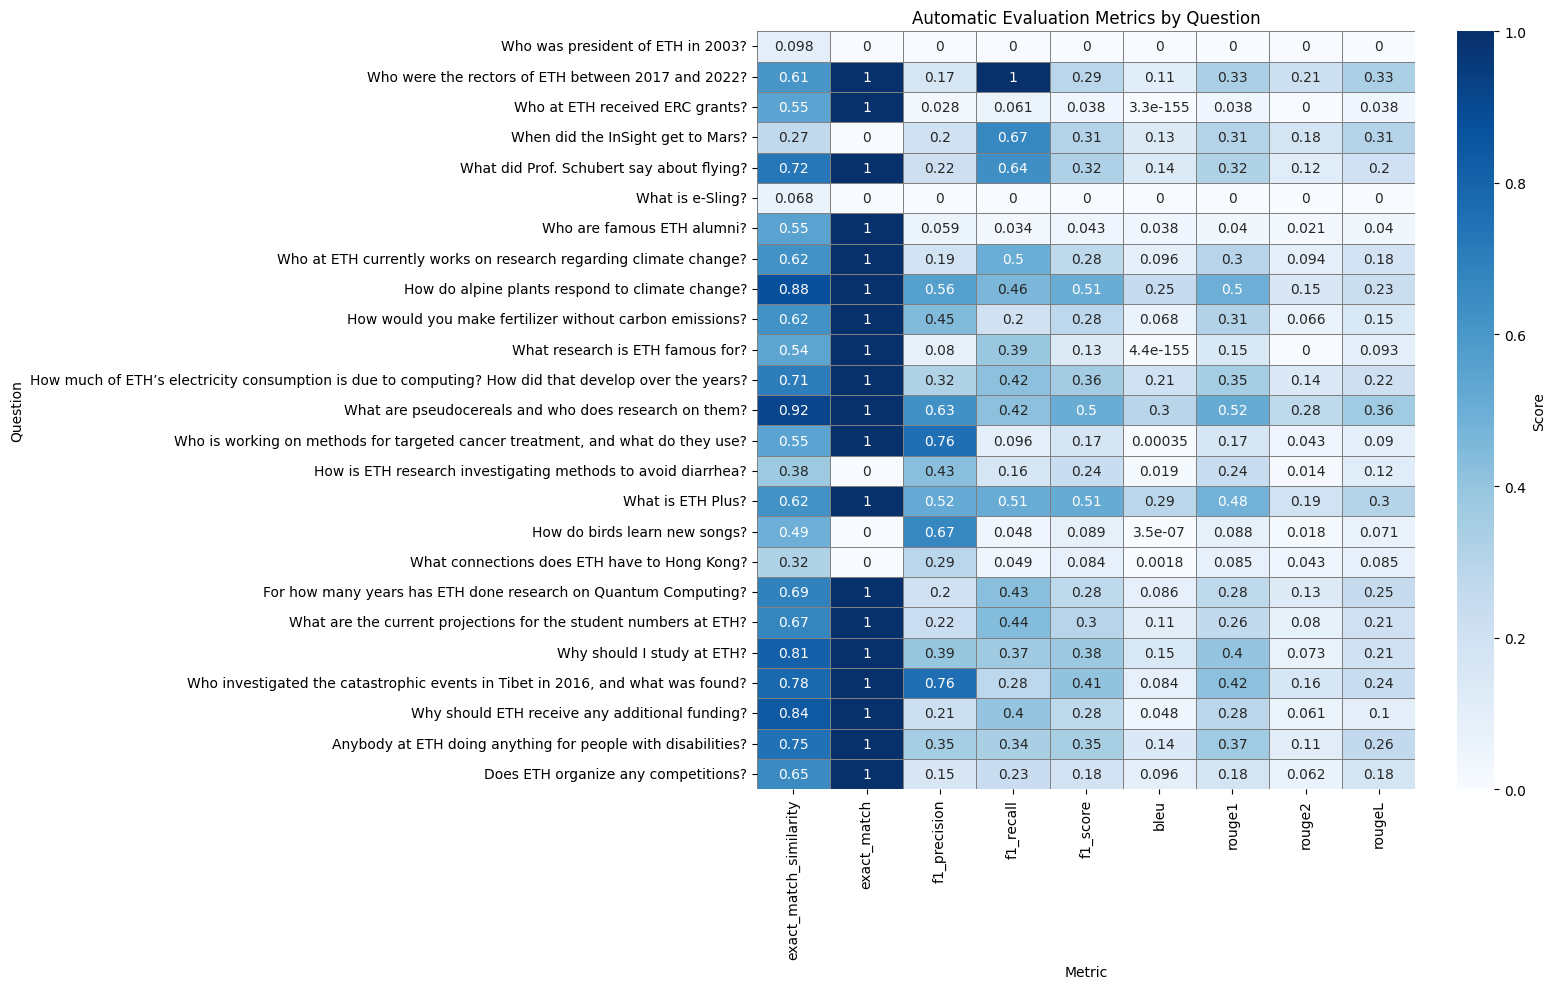

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numeric columns for the heatmap (exclude 'question' and any non-numeric columns)
numeric_cols = question_metrics.select_dtypes(include=['number', 'bool']).columns
# Convert boolean columns to float for heatmap
heatmap_data = question_metrics[numeric_cols].astype(float)
# Set the index to 'question' for better labeling
heatmap_data.index = question_metrics['question']

plt.figure(figsize=(16, len(heatmap_data) * 0.4))
sns.heatmap(
    heatmap_data,
    annot=True,
    cmap='Blues',
    linewidths=0.5,
    linecolor='gray',
    cbar_kws={'label': 'Score'}
)
plt.title("Automatic Evaluation Metrics by Question")
plt.xlabel("Metric")
plt.ylabel("Question")
plt.tight_layout()
plt.show()


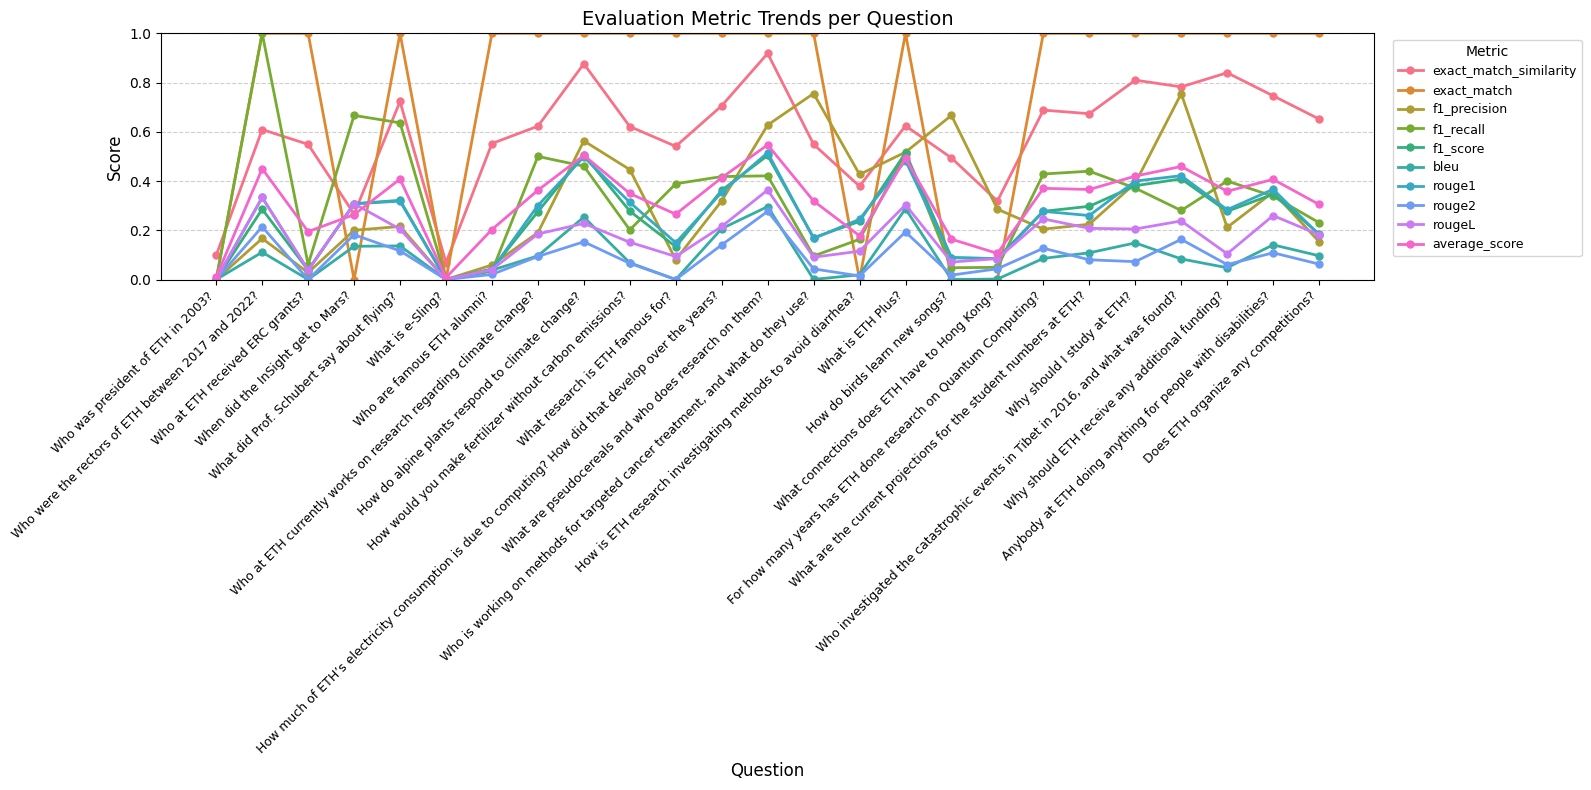

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set larger, readable figure
plt.figure(figsize=(16, 8))

# Define color palette
palette = sns.color_palette("husl", len(question_metrics.columns[1:]))

# Plot lines with smoother style and markers
for i, metric in enumerate(question_metrics.columns[1:]):
    plt.plot(
        question_metrics['question'],
        question_metrics[metric],
        marker='o',
        label=metric,
        color=palette[i],
        linewidth=2,
        markersize=5
    )

# Improve x-axis readability
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(fontsize=10)
plt.ylim(0, 1)
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.title("Evaluation Metric Trends per Question", fontsize=14)
plt.xlabel("Question", fontsize=12)
plt.ylabel("Score", fontsize=12)

# Shrink legend and place outside the plot
plt.legend(title="Metric", bbox_to_anchor=(1.01, 1), loc='upper left', fontsize=9)

# Tight layout for visibility
plt.tight_layout()
plt.show()


In [36]:
# Calculate the average score for each question across all metrics
question_metrics['average_score'] = question_metrics[metric_cols].mean(axis=1).astype(float)

# Find questions with the lowest average automated metric scores
automatic_lowest_5_questions = question_metrics.nsmallest(5, 'average_score')
print("❌ Questions with lowest overall automated metric scores:")
display(automatic_lowest_5_questions[['question', 'average_score']])

# Find questions with the highest average automated metric scores
automatic_top_5_questions = question_metrics.nlargest(5, 'average_score')
print("✅ Questions with highest overall automated metric scores:")
display(automatic_top_5_questions[['question', 'average_score']])

❌ Questions with lowest overall automated metric scores:


,question,average_score
5,What is e-Sling?,0.007585
0,Who was president of ETH in 2003?,0.010921
17,What connections does ETH have to Hong Kong?,0.105935
16,How do birds learn new songs?,0.163846
14,How is ETH research investigating methods to avoid diarrhea?,0.177575


✅ Questions with highest overall automated metric scores:


,question,average_score
12,What are pseudocereals and who does research on them?,0.546966
8,How do alpine plants respond to climate change?,0.504310
15,What is ETH Plus?,0.492739
21,"Who investigated the catastrophic events in Tibet in 2016, and what was found?",0.459195
1,Who were the rectors of ETH between 2017 and 2022?,0.450386


**Summary of Evaluation Insights**

- **Semantic metrics** such as exact_match_similarity and f1_score quantify the degree to which the generated answers align with the reference in meaning, and are expected to be higher in general as they capture semantic similarity rather than strict lexical overlap.
- **Lexical metrics** like BLEU and ROUGE-1/2/L measure n-gram overlap and structural consistency, which produces lower scores for answers that are paraphrased or structured differently from the reference.

### Key Observations
(*questions are labeled from 0 to 24*)
- **High-scoring questions** (e.g., Q12, Q8, Q21) consistently perform well across both semantic and lexical metrics, indicating strong context alignment and accurate generation.
- **Low-scoring questions** (e.g., Q0, Q5, Q13, Q16) often receive near-zero scores across all metrics, highlighting a failures in retrieval steps as seen in the previous document 2.2.
- **Binary-answer questions** (such as years or names) exhibit notable disparities between exact match and semantic F1 scores, as they are less suited for fuzzy matching. Example is Q3 *"When did the InSight get to Mars?"*, in where the answer is day month and year. Regardless, the LLM produced an answer with month and year, but not the day and some information about the mission, which is not relevant to the question. So the scores are low despite the answer being relevant.
- **Long-form explanation questions** (e.g., Q6, Q13, Q14) show significant variation between f1_score and ROUGE metrics, suggesting challenges related to verbosity and structural alignment. This questions are refered to more open-ended questions, usually leading to a possible list of people or events, which the LLM answers with the aknowledgment that there are several people and offers examples, but is far from the ground truth answer that is a fairly long list of people.

### Possible Improvements
- **Retrieval Enhancements:** Improve the retrieval step to ensure more relevant context is provided for each question, especially for those with low scores. Despite developing the retrieval system using and comparing different methods and choosing the best one, there is still room for improvement.
- **Ground Truth Alignment:** Ensure that the ground truth answers are well-structured and consistent in format to facilitate better comparison with generated answers. Some of the ground truth answers are 5 words long, while others are several, some are lists, while others are fully coherent paragraphs. This leads to a mismatch in the evaluation metrics.
- **Model Prompting:** Refine the LLM prompting, related to the above point about ground truth alignment, to encourage more structured and concise responses that align better with the expected answer format. 

## 4.2 Summary of Human Evaluation Results

In [17]:
# Display only questions and human ratings
human_eval_df = qa_df[['question', 'relevance_rating', 'correctness_rating', 'clarity_rating']]

C:\Users\advar\AppData\Local\Temp\ipykernel_39800\856869751.py:13: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  plt.tight_layout()
C:\Users\advar\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


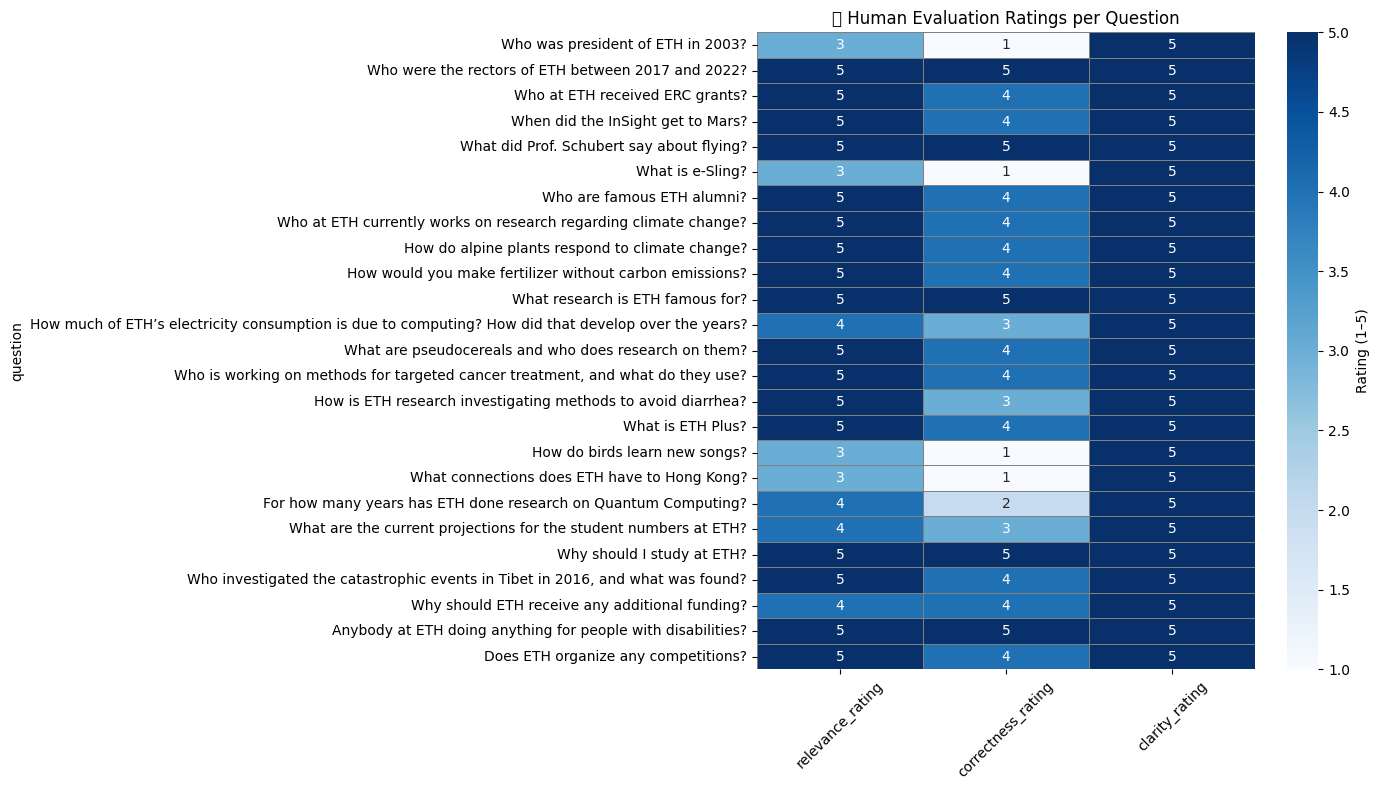

In [9]:
import seaborn as sns

plt.figure(figsize=(14, 8))
sns.heatmap(
	human_eval_df.set_index('question'),
	annot=True, cmap='Blues',
	linewidths=0.4, linecolor='gray',
	vmin=1, vmax=5,
	cbar_kws={'label': 'Rating (1–5)'}
)
plt.title("🔍 Human Evaluation Ratings per Question")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [6]:
# Show mean, std, min, max, etc.
human_eval_df[['relevance_rating', 'correctness_rating', 'clarity_rating']].describe()


,relevance_rating,correctness_rating,clarity_rating
count,25.000000,25.00000,25.0
mean,4.520000,3.52000,5.0
std,0.770281,1.32665,0.0
min,3.000000,1.00000,5.0
25%,4.000000,3.00000,5.0
50%,5.000000,4.00000,5.0
75%,5.000000,4.00000,5.0
max,5.000000,5.00000,5.0


C:\Users\advar\AppData\Local\Temp\ipykernel_39800\1804648234.py:13: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
C:\Users\advar\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


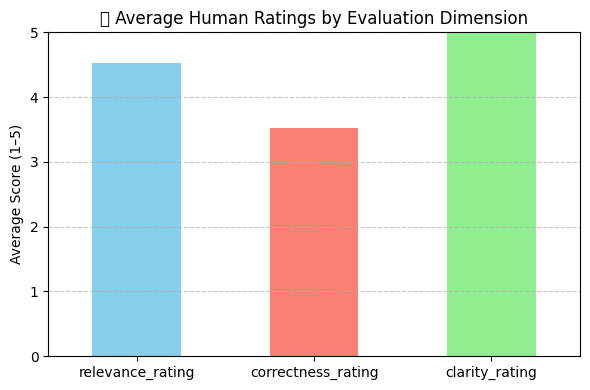

In [7]:
import matplotlib.pyplot as plt

# Calculate means
mean_scores = human_eval_df[['relevance_rating', 'correctness_rating', 'clarity_rating']].mean()

# Plot
mean_scores.plot(kind='bar', figsize=(6, 4), color=['skyblue', 'salmon', 'lightgreen'])
plt.title('📊 Average Human Ratings by Evaluation Dimension')
plt.ylabel('Average Score (1–5)')
plt.xticks(rotation=0)
plt.ylim(0, 5)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


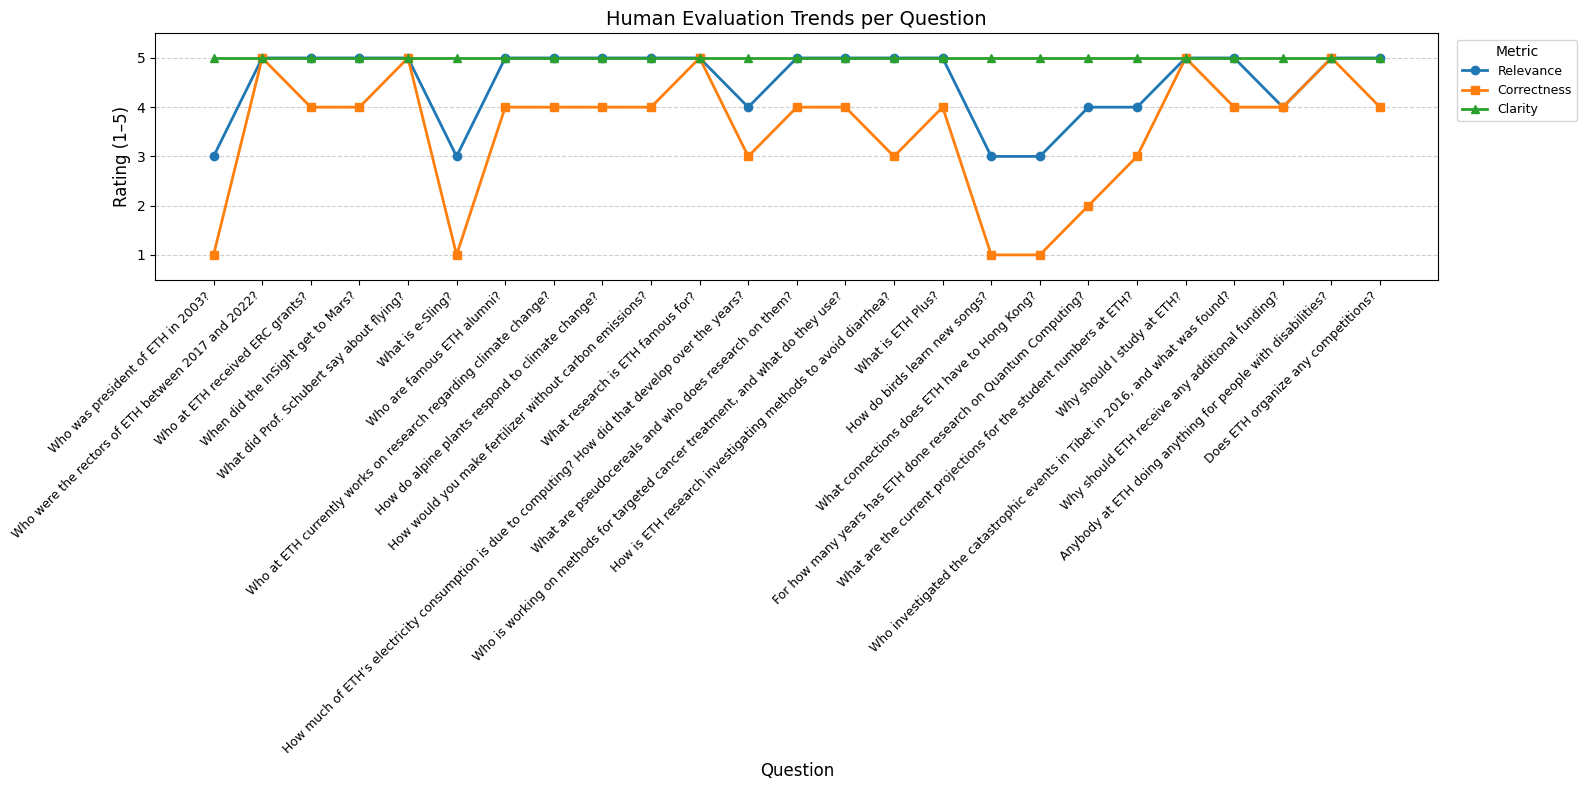

In [54]:
# Use human_eval_df directly for plotting human evaluation trends
plt.figure(figsize=(16, 8))
markers = ['o', 's', '^']
labels = ["Relevance", "Correctness", "Clarity"]
cols = ["relevance_rating", "correctness_rating", "clarity_rating"]

for col, marker, label in zip(cols, markers, labels):
    plt.plot(
        human_eval_df.index,
        human_eval_df[col],
        marker=marker,
        label=label,
        linewidth=2
    )

plt.xticks(human_eval_df.index, human_eval_df["question"], rotation=45, ha='right', fontsize=9)
plt.title("Human Evaluation Trends per Question", fontsize=14)
plt.xlabel("Question", fontsize=12)
plt.ylabel("Rating (1–5)", fontsize=12)
plt.ylim(0.5, 5.5)
plt.legend(title="Metric", bbox_to_anchor=(1.01, 1), loc='upper left', fontsize=9)
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



In [38]:
# Find questions with lowest correctness
human_lowest_5_questions = qa_df[qa_df["correctness_rating"] <= 2][["question", "correctness_rating"]]
print("❌ Bottom 5 Questions with lowest Human scores:")
display(human_lowest_5_questions)

# Find human_top_5_questions scores
human_top_5_questions = qa_df[(qa_df["relevance_rating"] == 5) &
                (qa_df["correctness_rating"] == 5) &
                (qa_df["clarity_rating"] == 5)][["question", "correctness_rating"]]
print("✅ Top 5 questions with better Human scores:")
display(human_top_5_questions)


❌ Bottom 5 Questions with lowest Human scores:


,question,correctness_rating
0,Who was president of ETH in 2003?,1.0
5,What is e-Sling?,1.0
16,How do birds learn new songs?,1.0
17,What connections does ETH have to Hong Kong?,1.0
18,For how many years has ETH done research on Quantum Computing?,2.0


✅ Top 5 questions with better Human scores:


,question,correctness_rating
1,Who were the rectors of ETH between 2017 and 2022?,5.0
4,What did Prof. Schubert say about ﬂying?,5.0
10,What research is ETH famous for?,5.0
20,Why should I study at ETH?,5.0
23,Anybody at ETH doing anything for people with disabilities?,5.0


## Comparing Human and Automated Evaluation

Finally, we compare the main human and automated evaluation metrics to identify any discrepancies or alignments between human judgment and automated scoring. This comparison helps validate the effectiveness of the automated metrics and highlights areas where human evaluation provides additional insights.

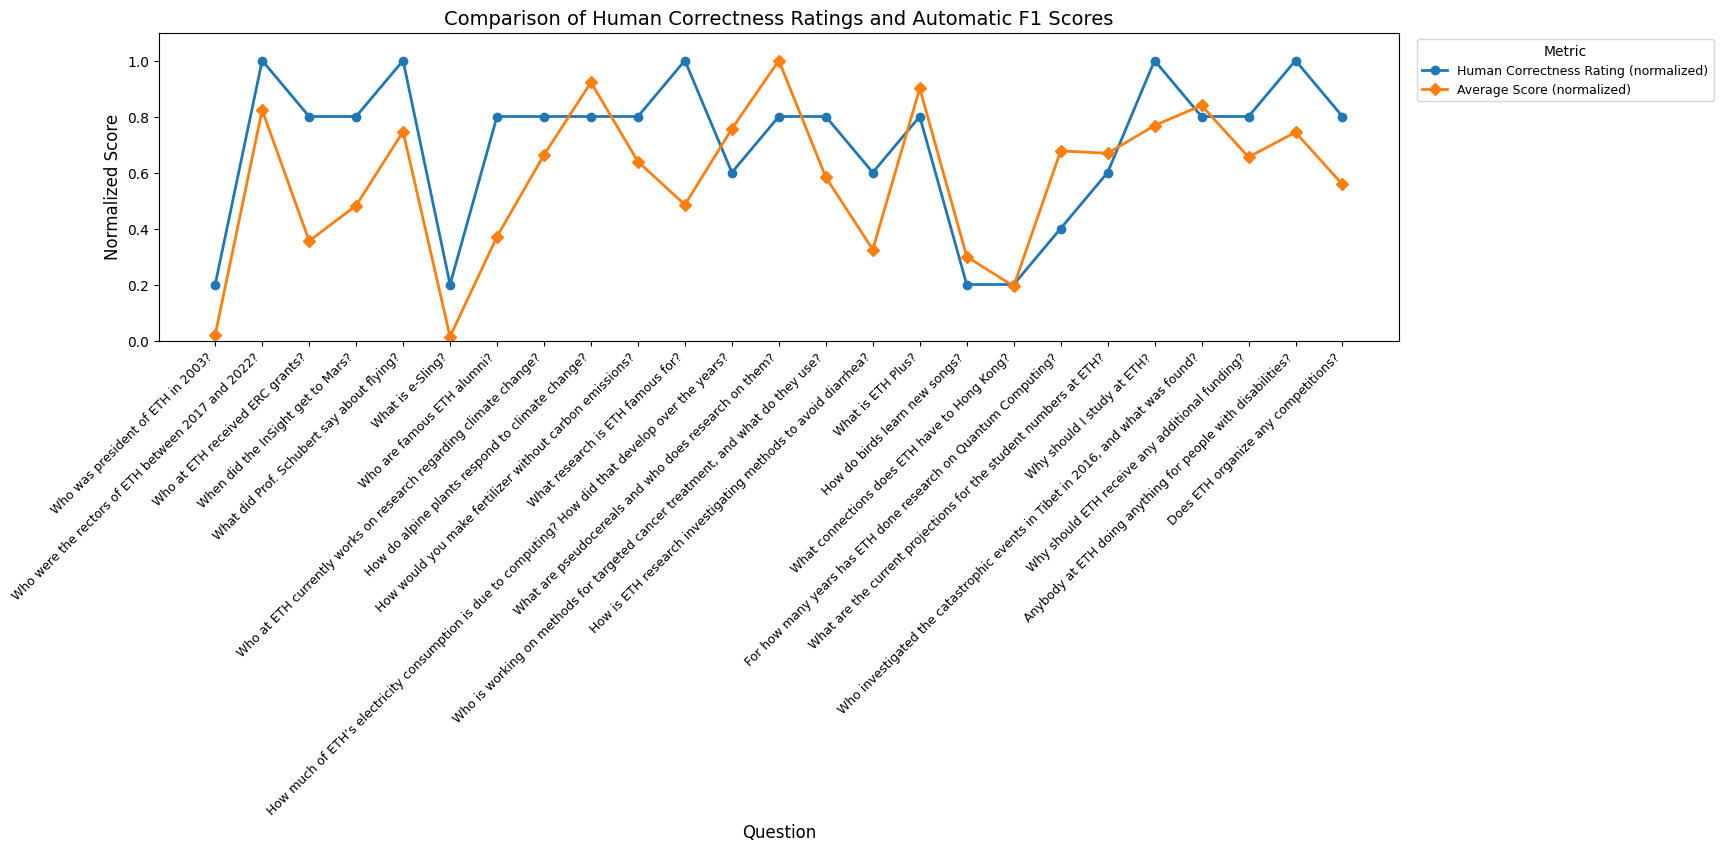

In [68]:
# line chart with human ratings correctness and automatic evaluation f1_score
plt.figure(figsize=(16, 4))
# Plot human correctness ratings
# Normalize human correctness ratings
human_correctness = human_eval_df['correctness_rating'] / human_eval_df['correctness_rating'].max()
plt.plot(
	human_eval_df.index,
	human_correctness,
	marker='o',
	label='Human Correctness Rating (normalized)',
	color='#1f77b4',  # blue
	linewidth=2
)

# add average score for machine evaluation
average_score_normalized = question_metrics['average_score'] / question_metrics['average_score'].max()
plt.plot(
	question_metrics.index,
	average_score_normalized,
	marker='D',
	label='Average Score (normalized)',
	color='#ff7f0e',  # orange
	linewidth=2
)

'''# Plot automatic F1 scores (normalized to [0,1] for comparison)
f1_score_normalized = question_metrics['f1_score'] / question_metrics['f1_score'].max()
plt.plot(
	question_metrics.index,
	f1_score_normalized,
	marker='s',
	label='Automatic F1 Score (normalized)',
	color='skyblue',
	linewidth=2,
	alpha=0.3
)

# add exact match similarity
exact_match_similarity_normalized = question_metrics['exact_match_similarity'] / question_metrics['exact_match_similarity'].max()
plt.plot(
	question_metrics.index,
	exact_match_similarity_normalized,
	marker='^',
	label='Exact Match Similarity (normalized)',
	color='lightgreen',
	linewidth=2,
	alpha=0.3
)'''

# adds X labels questions
plt.xticks(
	question_metrics.index,
	question_metrics['question'],
	rotation=45,
	ha='right',
	fontsize=9
)

# add legend, title, labels
plt.title("Comparison of Human Correctness Ratings and Automatic F1 Scores", fontsize=14)
plt.xlabel("Question", fontsize=12)
plt.ylabel("Normalized Score", fontsize=12)
plt.ylim(0, 1.1)
plt.legend(title="Metric", bbox_to_anchor=(1.01, 1), loc='upper left', fontsize=9)

The plot above shows the correlation between human ratings and automated metrics. Each point represents a question in the x-axis, with ratings on the y-axis. The ratings are the average of the automated metrics and the *correctness* human rating. This is done as the human ratings are more subjective and only correctness is a metric that can be compared to the automated metrics. For the automated metrics, other metrics such as *semantic_match* or *f1_score* could be used as well giving similar results. 

The plot highlights the highs and lows of both human and automated evaluations. Questions with low human ratings (e.g., Q0, Q5, Q16 and Q17) also have low automated scores, indicating that both evaluation methods agree on the poor quality of answers for these questions. Conversely, questions with high human ratings (e.g., Q2, Q5...) also tend to have high automated scores, suggesting that the RAG pipeline performs well on these queries.

There are 2 questions where the human ratings are significantly higher than the automated scores (Q3 "*Who at ETH received ERC grants?*" and Q11 "*What research is ETH famous for?*"). In both cases, the difference is maximum, while not being the most extreme outliers. 

In [ ]:
# compare the bottom 5 questions with lowest human correctness to the bottom 5 questions with lowest automated metrics
# Find the matching questions on both DataFrames
matching_questions = pd.merge(
	automatic_lowest_5_questions[['question']],
	human_lowest_5_questions[['question']],
	on='question',
	how='inner'
)

print("Matching Questions with Low Scores:")
display(matching_questions)


Matching Questions with Low Scores:


,question
0,What is e-Sling?
1,Who was president of ETH in 2003?
2,What connections does ETH have to Hong Kong?
3,How do birds learn new songs?


Matching Questions with High Scores:


,question
0,Who were the rectors of ETH between 2017 and 2022?


In [ ]:

# Compare the top 5 questions with highest human correctness to the top 5 questions with highest automated metrics
# Find the matching questions on both DataFrames
matching_top_questions = pd.merge(
	automatic_top_5_questions[['question']],
	human_top_5_questions[['question']],
	on='question',
	how='inner'
)

print("Matching Questions with High Scores:")
display(matching_top_questions)